In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'moth')
ims = results.attrgot('contentUrl')
len(ims)

150

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term).

**NB**: there's no way to be sure exactly what images a search like this will find. The results can change over time. We've heard of at least one case of a community member who found some unpleasant pictures of dead bears in their search results. You'll receive whatever images are found by the web search engine. If you're running this at work, or with kids, etc, then be cautious before you display the downloaded images.

Let's look at one:

In [6]:
results.attrgot('contentUrl')

(#150) ['https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Emperor_Gum_Moth.jpg/1200px-Emperor_Gum_Moth.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Polyphemus_Moth_Antheraea_polyphemus.JPG/1200px-Polyphemus_Moth_Antheraea_polyphemus.JPG','http://2.bp.blogspot.com/-ouCoKr0R1v0/UdyLj5AcmOI/AAAAAAAAA84/iqjlX8gbRVg/s1600/cecropia%2520moth%2520to%2520send.jpg','http://4.bp.blogspot.com/-9XYTkpIKYmw/VWhTlp1aRRI/AAAAAAAAKmw/q-wlN8M_jUo/s1600/IMG_0524.JPG','https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Pyrausta.aurata.7571.JPG/1200px-Pyrausta.aurata.7571.JPG','https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Moth_kerala.jpg/220px-Moth_kerala.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Orthopygia.glaucinalis.7371.jpg/1200px-Orthopygia.glaucinalis.7371.jpg','https://lh6.googleusercontent.com/-SL2d7zLArwM/TXOqoCdCYQI/AAAAAAAABhk/9pzaRrEdVTc/s1600/lep_columbia_moth071.JPG','https://i.ytimg.com/vi/Y-3ObKHY8YU/maxresdefault.jpg','h

In [7]:
#hide
ims = ['https://upload.wikimedia.org/wikipedia/commons/3/34/Noctua_pronuba1.jpg']

In [8]:
dest = 'images/moth.jpg'
download_url(ims[0], dest)
# dest = 'images/sports_car.jpg'
# download_url(ims[0], dest)

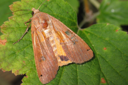

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [10]:
Lepidoptera = 'moth','butterfly'
path = Path('Lepidoptera')

In [11]:
if not path.exists():
    path.mkdir()
    for o in Lepidoptera:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))   

Our folder has image files, as we'd expect:

In [12]:
fns = get_image_files(path)
fns

(#284) [Path('Lepidoptera/moth/00000047.jpg'),Path('Lepidoptera/moth/00000055.jpg'),Path('Lepidoptera/moth/00000029.gif'),Path('Lepidoptera/moth/00000107.jpg'),Path('Lepidoptera/moth/00000036.jpg'),Path('Lepidoptera/moth/00000030.jpg'),Path('Lepidoptera/moth/00000097.jpg'),Path('Lepidoptera/moth/00000148.jpg'),Path('Lepidoptera/moth/00000112.jpg'),Path('Lepidoptera/moth/00000091.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [13]:
failed = verify_images(fns)
failed

(#2) [Path('Lepidoptera/butterfly/00000048.jpg'),Path('Lepidoptera/butterfly/00000060.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [14]:
failed.map(Path.unlink);

In [23]:
winged_insects = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                           get_items=get_image_files, 
                           splitter=RandomSplitter(valid_pct=0.2),
                           get_y=parent_label,
                           item_tfms=RandomResizedCrop(224, min_scale=0.5),
                           batch_tfms=aug_transforms())

In [24]:
dls = winged_insects.dataloaders(path)

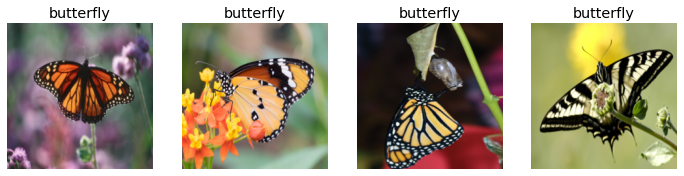

In [25]:
dls.valid.show_batch(max_n=4, nrows=1)

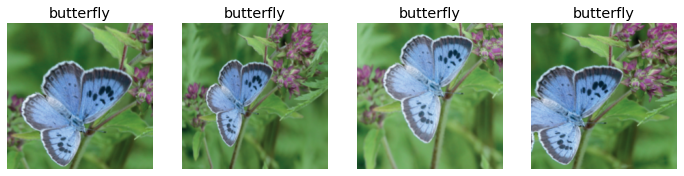

In [26]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We can now create our `Learner` and fine-tune it in the usual way:

In [27]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.179335,0.272941,0.125000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.508521,0.226403,0.071429,00:09
1,0.329211,0.200526,0.053571,00:08
2,0.239700,0.206610,0.035714,00:08
3,0.193986,0.211643,0.035714,00:08


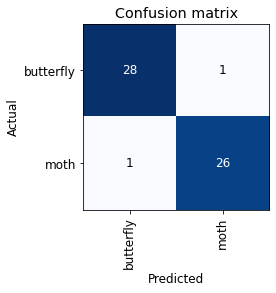

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

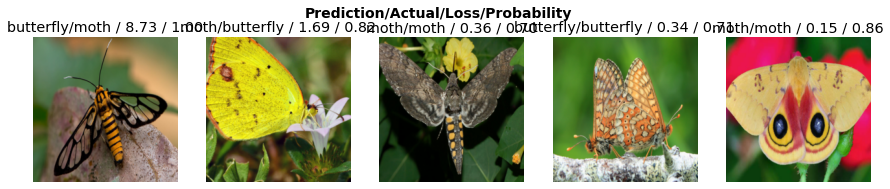

In [29]:
interp.plot_top_losses(5, nrows=1)

In [30]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [34]:
winged_insects = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                           get_items=get_image_files, 
                           splitter=RandomSplitter(valid_pct=0.2),
                           get_y=parent_label,
                           item_tfms=RandomResizedCrop(224, min_scale=0.5),
                           batch_tfms=aug_transforms())
dls = winged_insects.dataloaders(path)

In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.268110,0.434343,0.160714,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.438082,0.230922,0.107143,00:08
1,0.315764,0.086300,0.017857,00:10
2,0.229756,0.070349,0.035714,00:10
3,0.189555,0.072379,0.017857,00:09


In [36]:
learn.export('desafio5.pkl')

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('desafio5.pkl')]